# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

*This notebook was generated with the assistance of AI. Please review all code and interpretations carefully before using them in your research.*

---

## Overview

This notebook introduces and explores data from [Dandiset 001366 (v0.250324.1603)](https://dandiarchive.org/dandiset/001366/0.250324.1603), titled **"Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification"**.

The dataset contains high-resolution imaging movies of pial vessels in mice, designed for benchmarking vessel quantification algorithms. The imaging data is stored as NWB files containing tens of thousands of frames, capturing physiological vessel activity and pulsation.

---

## What this notebook covers

- How to list and access file assets in this dandiset using the DANDI Python API
- How to inspect the structure of the NWB files and identify key data groups
- How to load frames and metadata directly from the remote NWB files (streaming)
- How to visualize a sample image frame and explore temporal dynamics, such as:
    - Time series of the global mean frame intensity
    - Time series of a single pixel of interest

---

## Required Packages

The following Python packages are required (make sure they are installed on your system):

- dandi
- remfile
- h5py
- numpy
- matplotlib

No additional installation commands are included, as per instructions.

---

## 1. Listing Assets in Dandiset 001366

We start by using the DANDI API to list the NWB files included in this dandiset version.

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "001366"
dandiset_version = "0.250324.1603"

# Connect to the DANDI API and get the dandiset
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    # List all NWB assets
    nwb_files = [asset.path for asset in dandiset.get_assets_by_glob("*.nwb")]

print("NWB files in the dandiset:")
for path in nwb_files:
    print("-", path)

NWB files in the dandiset:
- sub-F15/sub-F15_ses-F15BC-19102023_image.nwb
- sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb


## 2. Exploring the First NWB File

Let's start by inspecting the first NWB file in the dandiset:  
**sub-F15/sub-F15_ses-F15BC-19102023_image.nwb**

We'll list the major groups and datasets it contains.

In [2]:
import h5py
import remfile

nwb_path = nwb_files[0]  # Use the first file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')

    # Recursively print dataset/group names
    def print_hierarchy(name, obj):
        if isinstance(obj, h5py.Group):
            print(f'Group: {name}')
        elif isinstance(obj, h5py.Dataset):
            print(f'  Dataset: {name} | shape={obj.shape}, dtype={obj.dtype}')

    print(f"Groups/datasets in {nwb_path}:")
    h5_file.visititems(print_hierarchy)

Groups/datasets in sub-F15/sub-F15_ses-F15BC-19102023_image.nwb:
Group: acquisition
Group: acquisition/Movies


  Dataset: acquisition/Movies/data | shape=(9553, 214, 132), dtype=uint16
  Dataset: acquisition/Movies/starting_time | shape=(), dtype=float64
Group: analysis
  Dataset: file_create_date | shape=(1,), dtype=object
Group: general
Group: general/devices
  Dataset: general/experiment_description | shape=(), dtype=object
  Dataset: general/experimenter | shape=(1,), dtype=object
Group: general/extracellular_ephys
  Dataset: general/institution | shape=(), dtype=object
Group: general/intracellular_ephys
  Dataset: general/keywords | shape=(1,), dtype=object
Group: general/optogenetics
Group: general/optophysiology
  Dataset: general/session_id | shape=(), dtype=object
Group: general/subject
  Dataset: general/subject/age | shape=(), dtype=object
  Dataset: general/subject/description | shape=(), dtype=object
  Dataset: general/subject/sex | shape=(), dtype=object
  Dataset: general/subject/species | shape=(), dtype=object
  Dataset: general/subject/strain | shape=(), dtype=object
  Dataset

### Main Imaging Data

The primary imaging data is stored in:
```
acquisition/Movies/data
```
This contains a (9553, 214, 132) array: 9553 time frames of 214x132 pixel images. Each pixel is a 16-bit unsigned integer.

---

## 3. Visualizing a Sample Movie Frame

We'll extract the very first frame and visualize it using `matplotlib`.

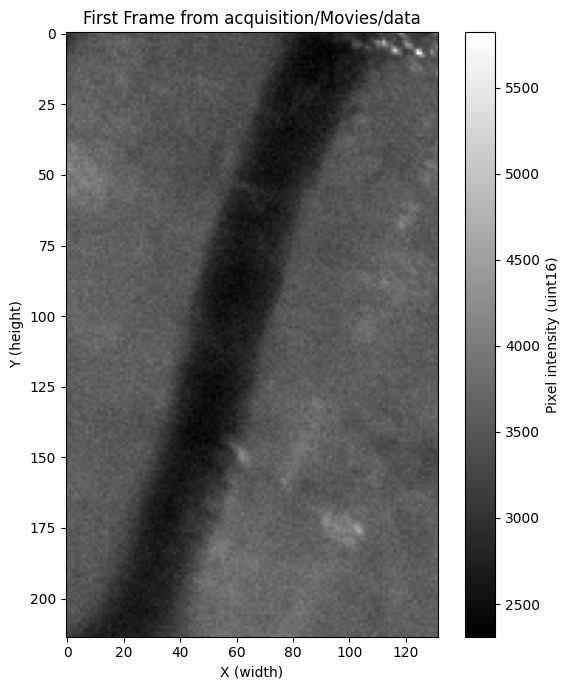

In [3]:
# Extract and display the first frame
import matplotlib.pyplot as plt

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')
    frame0 = h5_file["acquisition/Movies/data"][0, :, :]

plt.figure(figsize=(6, 7))
plt.imshow(frame0, cmap='gray')
plt.title('First Frame from acquisition/Movies/data')
plt.xlabel('X (width)')
plt.ylabel('Y (height)')
plt.colorbar(label='Pixel intensity (uint16)')
plt.tight_layout()
plt.show()

## 4. Plotting Average Frame Intensity Over Time

Next, we compute and plot the global mean intensity for each frame. This gives an overview of how overall brightness changes during the movie.

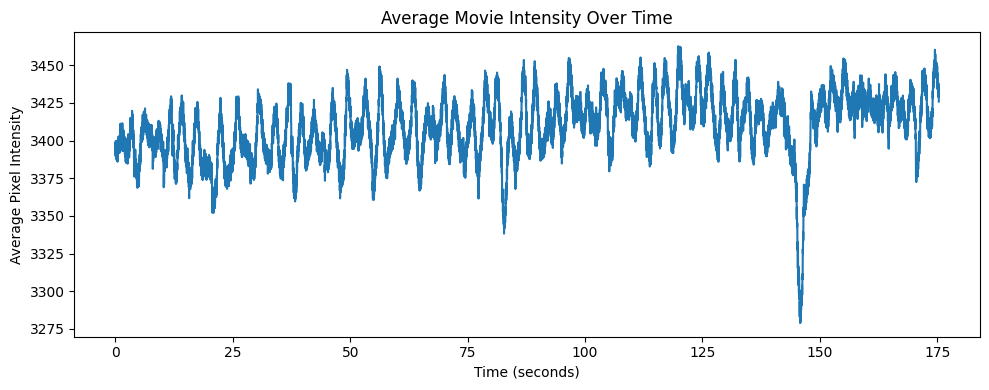

In [4]:
import numpy as np

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')
    data = h5_file["acquisition/Movies/data"]
    n_frames = data.shape[0]
    # According to metadata inspection, frame rate is 54.47 Hz
    frame_rate = 54.47
    starting_time = h5_file["acquisition/Movies/starting_time"][()]
    movie_mean = np.zeros(n_frames)
    for i in range(n_frames):
        movie_mean[i] = data[i, :, :].mean()
    time = starting_time + np.arange(n_frames) / frame_rate

plt.figure(figsize=(10, 4))
plt.plot(time, movie_mean)
plt.xlabel('Time (seconds)')
plt.ylabel('Average Pixel Intensity')
plt.title('Average Movie Intensity Over Time')
plt.tight_layout()
plt.show()

## 5. Time Course of an Example Pixel

We can inspect the dynamics at a specific location, e.g. (y=100, x=66) near the vessel center, as a single-pixel time series.

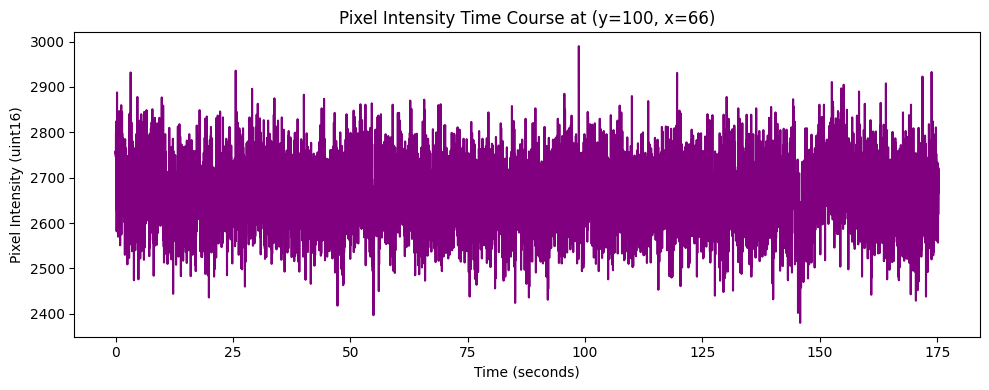

In [5]:
pixel_y, pixel_x = 100, 66

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')
    data = h5_file["acquisition/Movies/data"]
    n_frames = data.shape[0]
    # Use previously extracted time axis (frame_rate, starting_time)
    pixel_trace = data[:, pixel_y, pixel_x]

plt.figure(figsize=(10, 4))
plt.plot(time, pixel_trace, color='purple')
plt.xlabel('Time (seconds)')
plt.ylabel('Pixel Intensity (uint16)')
plt.title(f'Pixel Intensity Time Course at (y={pixel_y}, x={pixel_x})')
plt.tight_layout()
plt.show()

---
## 6. Exploring the Second NWB File

Now let's inspect the second NWB file:

**sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb**

We'll list the structure, view the first frame, and plot the average frame intensity over time.

In [6]:
nwb_path2 = nwb_files[1]

with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path2))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')

    print(f"Groups/datasets in {nwb_path2}:")
    h5_file.visititems(print_hierarchy)

Groups/datasets in sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb:
Group: acquisition
Group: acquisition/Movies


  Dataset: acquisition/Movies/data | shape=(6000, 512, 512), dtype=uint16
  Dataset: acquisition/Movies/starting_time | shape=(), dtype=float64
Group: analysis
  Dataset: file_create_date | shape=(1,), dtype=object
Group: general
Group: general/devices
  Dataset: general/experiment_description | shape=(), dtype=object
  Dataset: general/experimenter | shape=(1,), dtype=object
Group: general/extracellular_ephys
  Dataset: general/institution | shape=(), dtype=object
Group: general/intracellular_ephys
  Dataset: general/keywords | shape=(1,), dtype=object
Group: general/optogenetics
Group: general/optophysiology
  Dataset: general/session_id | shape=(), dtype=object
Group: general/subject
  Dataset: general/subject/age | shape=(), dtype=object
  Dataset: general/subject/description | shape=(), dtype=object
  Dataset: general/subject/sex | shape=(), dtype=object
  Dataset: general/subject/species | shape=(), dtype=object
  Dataset: general/subject/strain | shape=(), dtype=object
  Dataset

The primary movie here is stored as a (6000, 512, 512) array of 16-bit frames.

### Visualize the First Frame of the Second Movie

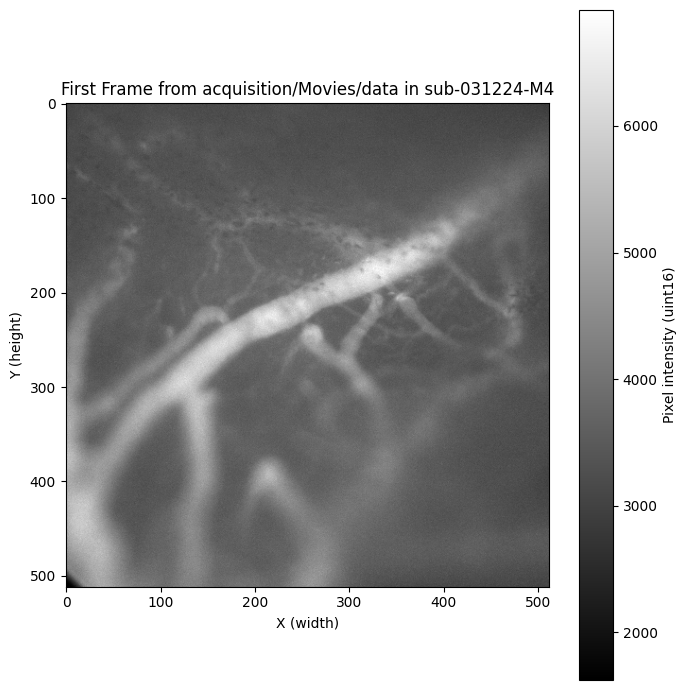

In [7]:
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path2))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')
    frame0_2 = h5_file["acquisition/Movies/data"][0, :, :]

plt.figure(figsize=(7, 7))
plt.imshow(frame0_2, cmap='gray')
plt.title('First Frame from acquisition/Movies/data in sub-031224-M4')
plt.xlabel('X (width)')
plt.ylabel('Y (height)')
plt.colorbar(label='Pixel intensity (uint16)')
plt.tight_layout()
plt.show()

### Average Frame Intensity Over Time (Second File)

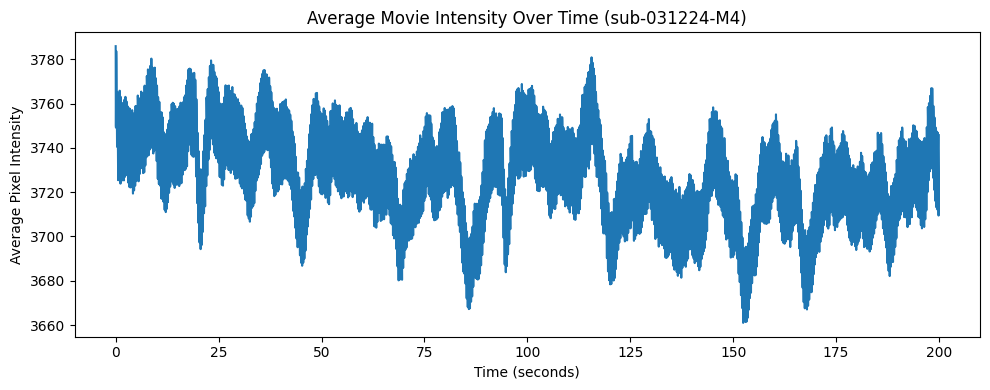

In [8]:
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(nwb_path2))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file, 'r')
    data = h5_file["acquisition/Movies/data"]
    n_frames = data.shape[0]
    # Metadata shows the rate is 30.0 Hz
    frame_rate2 = 30.0
    starting_time2 = h5_file["acquisition/Movies/starting_time"][()]
    movie_mean2 = np.zeros(n_frames)
    for i in range(n_frames):
        movie_mean2[i] = data[i, :, :].mean()
    time2 = starting_time2 + np.arange(n_frames) / frame_rate2

plt.figure(figsize=(10, 4))
plt.plot(time2, movie_mean2)
plt.xlabel('Time (seconds)')
plt.ylabel('Average Pixel Intensity')
plt.title('Average Movie Intensity Over Time (sub-031224-M4)')
plt.tight_layout()
plt.show()

## Summary and Next Steps

This notebook demonstrated how to:
- List and stream NWB files directly from the DANDI Archive
- Explore file structure to identify main imaging and metadata locations
- Visualize individual movie frames for vessel imaging data
- Analyze global and local (single-pixel) temporal dynamics in these neuroimaging movies

For further analysis, consider exploring:
- More advanced pixel or ROI extraction
- Quantification of pulsatility or event-related changes
- Automation for batch exploration of future DANDI sets

For more information, see the [Dandiset 001366 landing page](https://dandiarchive.org/dandiset/001366/0.250324.1603).